# Generate data
- Target: generate n (default n = 24) rows for each stay_id, with the following 30 columns
    - baseline (9 cols): age, gender, insurance type, race, first care unit ICU, Admission type, Height, Weight, Tobacco
    - ventilation (9 cols): peep, fio2, tidal_volume_observed, ~~O2 flow~~ (drop due to too many missing), respiratory_rate_set, Plateau pressure, RSBI: resp_rate / tidal_volume_observed, minute_ventilation: resp_rate * tidal_volume_observed, ventilator_mode, ventilator_mode_group
    - vitalsign (6 cols): heart_rate, sbp, dbp, mbp, spO2, resp_rate
    - id_info (6 cols): subject_id, stay_id, hadm_id, charttime, before_weaning_hr, label
- Baseline features steps:
    1. Read in data
    2. Merge with ground truth ("label")
    3. Show tableone for the Baseline features with missing value and outliers
    4. Use KNN for the missing value on weight and height
    5. Deal with outlier by 3 std as boundary
    6. Show tableone for the Baseline features after deal with outliers
- Charttime featrues steps:
    1. Round the charttime to hour
    2. Filter the charttime data start / end from ventilation starttime / endtime within 24 hr
    3. Fill the missing value forward then backward by stay_id by each of the charttime df (ventilator_setting_df, vitalsign_df, labevents_df)
    4. Generate template: n rows for each stay_id, # of total rows = n * # of stay_id
    5. Merge template with charttime dataframes (left join): some hour might be empty, while some hour might have more than one rows
    6. Fill the missing value again (some missing value might appear when step 5. merge into 24 rows)
    7. Use aggregation function dealing with "one hour with multiple line" (e.g., vitalsign: one hour have two records -> merge into one row)
    8. Calculate 'RSBI' and 'minute_ventilation' by 'tidal_volume_observed' and 'resp_rate'
    9. Merge with ground truth ("label")
    10. Show tableone for the Charttime features with missing value and outliers
    11. Deal with outlier by 3 std as boundary
    12. Show tableone for the Baseline features after deal with outliers

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.impute import KNNImputer
from tableone import TableOne, load_dataset
pd.options.mode.chained_assignment = None

## Baseline features

### Read in data

In [2]:
baseline_df = pd.read_csv("data/data_by_table/baseline.csv")
ventilator_setting_df = pd.read_csv("data/data_by_table/mimiciv_derived_ventilator_setting.csv")
vitalsign_df = pd.read_csv("data/data_by_table/mimiciv_derived_vitalsign.csv")
# labevents_df = pd.read_csv("data/data_by_table/mimiciv_hosp_labevents.csv")
labevents_df = pd.read_csv("data/data_by_table/mimiciv_hosp_labevents_itemid_50821.csv")
cohort_subject_id_stay_id_df = pd.read_csv("data/data_by_table/cohort_subject_id_stay_id.csv")
ground_truth_df = pd.read_csv("data/data_by_table/ground_truth.csv")
labevents_df['O2_flow'].replace('___', pd.NA, inplace=True)

In [3]:
baseline_df

,subject_id,stay_id,hadm_id,age_now,gender,insurance,race,admission_type,first_careunit,weight_kg,height_cm,tobacco
0,10352416,35043893,21251271,23,M,Other,WHITE,EW EMER.,Trauma SICU (TSICU),87.3,180.0,1
1,18043720,32368521,25619766,37,M,Medicaid,HISPANIC OR LATINO,EW EMER.,Surgical Intensive Care Unit (SICU),115.5,188.0,0
2,16767959,31389801,22062066,40,M,Other,UNKNOWN,URGENT,Cardiac Vascular Intensive Care Unit (CVICU),63.5,175.0,1
3,17886844,30829378,20868449,41,F,Medicaid,BLACK/AFRICAN AMERICAN,URGENT,Medical Intensive Care Unit (MICU),80.2,160.0,1
4,14147585,32013423,23216220,46,F,Medicare,ASIAN,EW EMER.,Medical/Surgical Intensive Care Unit (MICU/SICU),45.9,152.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2835,16643806,34351511,20247409,70,M,Other,WHITE,EW EMER.,Medical/Surgical Intensive Care Unit (MICU/SICU),99.5,178.0,0
2836,11344751,33181285,27728838,60,F,Medicaid,BLACK/AFRICAN AMERICAN,EW EMER.,Medical Intensive Care Unit (MICU),102.5,160.0,1
2837,10933807,34478477,25367629,63,M,Medicare,WHITE - EASTERN EUROPEAN,SURGICAL SAME DAY ADMISSION,Surgical Intensive Care Unit (SICU),87.6,165.0,0
2838,12648465,32471162,22702738,54,F,Medicare,BLACK/AFRICAN AMERICAN,OBSERVATION ADMIT,Trauma SICU (TSICU),116.0,165.0,1


In [4]:
baseline_df.columns

Index(['subject_id', 'stay_id', 'hadm_id', 'age_now', 'gender', 'insurance',
       'race', 'admission_type', 'first_careunit', 'weight_kg', 'height_cm',
       'tobacco'],
      dtype='object')

In [5]:
ground_truth_df

,stay_id,starttime,endtime,next_starttime,next_endtime,re_vent_time_diff,dod,weaning_till_dod_hr,weaning_till_dod_day,hospital_expire_flag,re_vent_in_48,this_vent_failed,label
0,30005707,2144-01-07T00:00:00,2144-01-12 19:47:00,NaN,NaN,NaN,2149-10-29,50788.216667,2116.175694,0,0,0,1
1,30006983,2159-10-12T18:00:00,2159-11-02 00:00:00,2159-11-09T20:00:00,2159-11-12T05:00:00,188.0,2159-11-22,480.000000,20.000000,1,0,0,1
2,30007565,2141-07-09T01:40:00,2141-07-15 09:00:00,2141-07-16T03:00:00,2141-07-20T16:00:00,18.0,NaN,NaN,NaN,0,1,1,0
3,30015010,2154-07-27T08:30:00,2154-08-13 10:50:00,NaN,NaN,NaN,2155-01-22,3877.166667,161.548611,0,0,0,1
4,30016026,2168-02-19T18:00:00,2168-02-28 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2835,39986206,2183-06-20T00:00:00,2183-07-01 17:34:00,2183-07-04T01:42:00,2183-07-07T20:00:00,56.0,NaN,NaN,NaN,0,0,0,1
2836,39986775,2123-10-07T22:00:00,2123-10-14 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1
2837,39986786,2145-02-20T14:23:00,2145-02-23 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1
2838,39990093,2145-08-06T21:00:00,2145-08-15 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1


### Merge with ground truth ("label")

In [6]:
baseline_gt_df = pd.merge(baseline_df, ground_truth_df[["stay_id", "label"]], on = ["stay_id"], how = "inner")
baseline_gt_df

,subject_id,stay_id,hadm_id,age_now,gender,insurance,race,admission_type,first_careunit,weight_kg,height_cm,tobacco,label
0,10352416,35043893,21251271,23,M,Other,WHITE,EW EMER.,Trauma SICU (TSICU),87.3,180.0,1,0
1,18043720,32368521,25619766,37,M,Medicaid,HISPANIC OR LATINO,EW EMER.,Surgical Intensive Care Unit (SICU),115.5,188.0,0,1
2,16767959,31389801,22062066,40,M,Other,UNKNOWN,URGENT,Cardiac Vascular Intensive Care Unit (CVICU),63.5,175.0,1,0
3,17886844,30829378,20868449,41,F,Medicaid,BLACK/AFRICAN AMERICAN,URGENT,Medical Intensive Care Unit (MICU),80.2,160.0,1,1
4,14147585,32013423,23216220,46,F,Medicare,ASIAN,EW EMER.,Medical/Surgical Intensive Care Unit (MICU/SICU),45.9,152.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2835,16643806,34351511,20247409,70,M,Other,WHITE,EW EMER.,Medical/Surgical Intensive Care Unit (MICU/SICU),99.5,178.0,0,0
2836,11344751,33181285,27728838,60,F,Medicaid,BLACK/AFRICAN AMERICAN,EW EMER.,Medical Intensive Care Unit (MICU),102.5,160.0,1,0
2837,10933807,34478477,25367629,63,M,Medicare,WHITE - EASTERN EUROPEAN,SURGICAL SAME DAY ADMISSION,Surgical Intensive Care Unit (SICU),87.6,165.0,0,1
2838,12648465,32471162,22702738,54,F,Medicare,BLACK/AFRICAN AMERICAN,OBSERVATION ADMIT,Trauma SICU (TSICU),116.0,165.0,1,1


### Show tableone for the Baseline features with missing value and outliers


In [7]:
features_col = ['age_now', 'gender', 'insurance', 'admission_type',
                'first_careunit', 'weight_kg', 'height_cm', 'tobacco', 'label'] # 'race'
categorical = ['gender', 'insurance', 'admission_type', 'first_careunit']   # 'race'
groupby = ['label']
table_with_outlier = TableOne(baseline_gt_df, columns=features_col, categorical=categorical, groupby=groupby, pval=True)
table_with_outlier

Grouped by label                                                  
                                                                                Missing       Overall             0             1 P-Value
n                                                                                                2840          1045          1795        
age_now, mean (SD)                                                                    0   61.4 (16.3)   64.0 (15.6)   60.0 (16.5)  <0.001
gender, n (%)         F                                                               0   1177 (41.4)    437 (41.8)    740 (41.2)   0.787
                      M                                                                   1663 (58.6)    608 (58.2)   1055 (58.8)        
insurance, n (%)      Medicaid                                                        0    292 (10.3)      94 (9.0)    198 (11.0)   0.092
                      Medicare                                                            1202 (42.3)    465 (44.5)    737 (41.1)        
                      Other                                                               1346 (47.4)    486 (46.5)    860 (47.9)        
admission_type, n (%) DIRECT EMER.                                                    0      91 (3.2)      38 (3.6)      53 (3.0)   0.156
                      ELECTIVE                                                               46 (1.6)      18 (1.7)      28 (1.6)        
                      EW EMER.                                                            1759 (61.9)    622 (59.5)   1137 (63.3)        
                      OBSERVATION ADMIT                                                     111 (3.9)      43 (4.1)      68 (3.8)        
                      SURGICAL SAME DAY ADMISSION                                           144 (5.1)      46 (4.4)      98 (5.5)        
                      URGENT                                                               689 (24.3)    278 (26.6)    411 (22.9)        
first_careunit, n (%) Cardiac Vascular Intensive Care Unit (CVICU)                    0     248 (8.7)      95 (9.1)     153 (8.5)   0.764
                      Coronary Care Unit (CCU)                                              264 (9.3)     100 (9.6)     164 (9.1)        
                      Medical Intensive Care Unit (MICU)                                   814 (28.7)    298 (28.5)    516 (28.7)        
                      Medical/Surgical Intensive Care Unit (MICU/SICU)                     392 (13.8)    157 (15.0)    235 (13.1)        
                      Neuro Surgical Intensive Care Unit (Neuro SICU)                        15 (0.5)       5 (0.5)      10 (0.6)        
                      Surgical Intensive Care Unit (SICU)                                  432 (15.2)    149 (14.3)    283 (15.8)        
                      Trauma SICU (TSICU)                                                  674 (23.7)    241 (23.1)    433 (24.1)        
                      Neuro Intermediate                                                      1 (0.0)                     1 (0.1)        
weight_kg, mean (SD)                                                                150   87.3 (28.4)   85.9 (27.5)   88.1 (28.9)   0.047
height_cm, mean (SD)                                                                476  169.6 (11.1)  169.2 (11.3)  169.9 (11.0)   0.151
tobacco, mean (SD)                                                                    0     0.4 (0.5)     0.4 (0.5)     0.4 (0.5)   0.764
[1] Chi-squared tests for the following variables may be invalid due to the low number of observations: first_careunit.

In [8]:
features_col = ['race', 'label']
categorical = ['race']   # 'race'
groupby = ['label']
table_with_outlier = TableOne(baseline_gt_df, columns=features_col, categorical=categorical, groupby=groupby, pval=True)
table_with_outlier

Grouped by label                                              
                                                               Missing      Overall           0            1 P-Value
n                                                                              2840        1045         1795        
race, n (%) AMERICAN INDIAN/ALASKA NATIVE                            0      4 (0.1)     2 (0.2)      2 (0.1)   0.026
            ASIAN                                                          21 (0.7)     6 (0.6)     15 (0.8)        
            ASIAN - CHINESE                                                31 (1.1)    15 (1.4)     16 (0.9)        
            ASIAN - KOREAN                                                  3 (0.1)     1 (0.1)      2 (0.1)        
            ASIAN - SOUTH EAST ASIAN                                        7 (0.2)     3 (0.3)      4 (0.2)        
            BLACK/AFRICAN                                                   8 (0.3)     2 (0.2)      6 (0.3)        
            BLACK/AFRICAN AMERICAN                                        247 (8.7)    92 (8.8)    155 (8.6)        
            BLACK/CAPE VERDEAN                                             17 (0.6)     3 (0.3)     14 (0.8)        
            BLACK/CARIBBEAN ISLAND                                         11 (0.4)     3 (0.3)      8 (0.4)        
            HISPANIC OR LATINO                                             36 (1.3)    11 (1.1)     25 (1.4)        
            HISPANIC/LATINO - CENTRAL AMERICAN                              2 (0.1)     1 (0.1)      1 (0.1)        
            HISPANIC/LATINO - COLUMBIAN                                     1 (0.0)     1 (0.1)                     
            HISPANIC/LATINO - DOMINICAN                                    17 (0.6)     3 (0.3)     14 (0.8)        
            HISPANIC/LATINO - MEXICAN                                       2 (0.1)     1 (0.1)      1 (0.1)        
            HISPANIC/LATINO - PUERTO RICAN                                 35 (1.2)    11 (1.1)     24 (1.3)        
            OTHER                                                         113 (4.0)    40 (3.8)     73 (4.1)        
            PATIENT DECLINED TO ANSWER                                     17 (0.6)     3 (0.3)     14 (0.8)        
            PORTUGUESE                                                     12 (0.4)     2 (0.2)     10 (0.6)        
            UNABLE TO OBTAIN                                               78 (2.7)    35 (3.3)     43 (2.4)        
            UNKNOWN                                                      356 (12.5)  163 (15.6)   193 (10.8)        
            WHITE                                                       1754 (61.8)  625 (59.8)  1129 (62.9)        
            WHITE - BRAZILIAN                                               5 (0.2)     1 (0.1)      4 (0.2)        
            WHITE - OTHER EUROPEAN                                         32 (1.1)    16 (1.5)     16 (0.9)        
            WHITE - RUSSIAN                                                12 (0.4)     5 (0.5)      7 (0.4)        
            ASIAN - ASIAN INDIAN                                            4 (0.1)                  4 (0.2)        
            HISPANIC/LATINO - GUATEMALAN                                    2 (0.1)                  2 (0.1)        
            HISPANIC/LATINO - HONDURAN                                      3 (0.1)                  3 (0.2)        
            HISPANIC/LATINO - SALVADORAN                                    1 (0.0)                  1 (0.1)        
            MULTIPLE RACE/ETHNICITY                                         2 (0.1)                  2 (0.1)        
            NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER                       5 (0.2)                  5 (0.3)        
            WHITE - EASTERN EUROPEAN                                        2 (0.1)                  2 (0.1)        
[1] Chi-squared tests for the following variables may be invalid due to the 

### Use KNN for the missing value on weight and height

In [9]:
def KNN_weight_height(baseline_gt_df):
    imputer = KNNImputer(n_neighbors=3)
    baseline_gt_df[['height_cm', 'weight_kg']] = imputer.fit_transform(baseline_gt_df[['height_cm', 'weight_kg']])
    baseline_gt_df['height_cm'].fillna(baseline_gt_df.groupby('gender')['height_cm'].transform('mean'), inplace=True)
    baseline_gt_df['weight_kg'].fillna(baseline_gt_df.groupby('gender')['weight_kg'].transform('mean'), inplace=True)
    return baseline_gt_df
    # baseline_df_p.drop(columns=['subject_id', 'hadm_id'])

In [10]:
baseline_fill_w_h_df = KNN_weight_height(baseline_gt_df)

In [11]:
features_col = ['weight_kg', 'height_cm', 'label']
categorical = []
groupby = ['label']
table_with_outlier = TableOne(baseline_fill_w_h_df, columns=features_col, categorical=categorical, groupby=groupby, pval=True)
table_with_outlier

Grouped by label                                                  
                               Missing       Overall             0             1 P-Value
n                                               2840          1045          1795        
weight_kg, mean (SD)                 0   87.3 (27.7)   86.0 (26.8)   88.1 (28.2)   0.051
height_cm, mean (SD)                 0  169.5 (10.6)  169.0 (10.7)  169.7 (10.5)   0.057

### Deal with outlier by 3 std as boundary

In [12]:
def handle_outliers(series, threshold=3):
    lower_bound = series.quantile(0.25) - threshold * (series.quantile(0.75) - series.quantile(0.25))
    upper_bound = series.quantile(0.75) + threshold * (series.quantile(0.75) - series.quantile(0.25))
    # print(f'upper_bound: {upper_bound}\n lower_bound: {lower_bound}')
    # print(series[series < lower_bound])
    # print(series[series > upper_bound])
    series[series < lower_bound] = lower_bound
    series[series > upper_bound] = upper_bound
    return series

In [13]:
numeric_columns = baseline_fill_w_h_df.select_dtypes(include=['float64', 'int64']).columns
numeric_columns = numeric_columns.drop(["stay_id", "subject_id", 'hadm_id', 'age_now', 'tobacco', 'label'])
# Apply the function to each numeric column
baseline_fill_w_h_df[numeric_columns] = baseline_fill_w_h_df[numeric_columns].apply(handle_outliers)

### Show tableone for the Baseline features after deal with outliers

In [14]:
features_col = ['weight_kg', 'height_cm', 'label']
categorical = []
groupby = ['label']
table_without_outlier = TableOne(baseline_fill_w_h_df, columns=features_col, categorical=categorical, groupby=groupby, pval=True)
table_without_outlier

Grouped by label                                                  
                               Missing       Overall             0             1 P-Value
n                                               2840          1045          1795        
weight_kg, mean (SD)                 0   87.0 (25.9)   85.7 (24.8)   87.7 (26.4)   0.041
height_cm, mean (SD)                 0  169.5 (10.3)  169.0 (10.4)  169.8 (10.3)   0.056

## Chattime features

### Round the charttime to hour

In [15]:
def round_hour(charttime_df):
    charttime_df['charttime'] = pd.to_datetime(charttime_df['charttime']).dt.round('H')
    return charttime_df

In [16]:
ventilator_setting_round_df = round_hour(ventilator_setting_df)
vitalsign_round_df = round_hour(vitalsign_df)
labevents_round_df = round_hour(labevents_df)

### Filter the charttime data start / end from ventilation starttime / endtime within 24 hr

In [17]:
def filter_starttime_endtime(ground_truth_df, charttime_df, filter_hours):
    filter_starttime_endtime_df = pd.DataFrame()
    for index, row in ground_truth_df.iterrows():
        start_time = pd.to_datetime(row['starttime']) - timedelta(hours=filter_hours)
        end_time = pd.to_datetime(row['endtime']) + timedelta(hours=filter_hours)
        stay_id = row['stay_id']
        df_subset = charttime_df[(charttime_df['stay_id'] == stay_id) & (charttime_df['charttime'] >= start_time) & (charttime_df['charttime'] <= end_time)]
        filter_starttime_endtime_df = pd.concat([filter_starttime_endtime_df, df_subset])
    return filter_starttime_endtime_df

In [18]:
print(len(ventilator_setting_df))
print(len(vitalsign_df))
print(len(labevents_df))

259057
1278635
94661


In [19]:
filter_hours = 24
ventilator_setting_filter_df = filter_starttime_endtime(ground_truth_df, ventilator_setting_round_df, filter_hours)
vitalsign_filter_df = filter_starttime_endtime(ground_truth_df, vitalsign_round_df, filter_hours)
labevents_filter_df = filter_starttime_endtime(ground_truth_df, labevents_round_df, filter_hours)

In [20]:
print(len(ventilator_setting_filter_df))
print(len(vitalsign_filter_df))
print(len(labevents_filter_df))

195416
841949
60842


In [21]:
filter_hours = 0
ventilator_setting_filter_0_df = filter_starttime_endtime(ground_truth_df, ventilator_setting_filter_df, filter_hours)
vitalsign_filter_0_df = filter_starttime_endtime(ground_truth_df, vitalsign_filter_df, filter_hours)
labevents_filter_0_df = filter_starttime_endtime(ground_truth_df, labevents_filter_df, filter_hours)

In [22]:
print(len(ventilator_setting_filter_0_df))
print(len(vitalsign_filter_0_df))
print(len(labevents_filter_0_df))

181273
731520
53581


### Fill the missing value forward then backward by stay_id by each of the charttime df (ventilator_setting_df, vitalsign_df, labevents_df)

In [23]:
def fill_Nan(df):
    # Convert 'charttime' to datetime format for sorting
    df['charttime'] = pd.to_datetime(df['charttime'])
    # Sort DataFrame by 'stay_id' and 'charttime'
    df.sort_values(by=['stay_id', 'charttime'], inplace=True)
    # Fill NaN values within each 'stay_id' using forward-fill and backward-fill
    df = df.groupby('stay_id').apply(lambda group: group.ffill().bfill())
    
    return df

In [24]:
ventilator_setting_fill_df = fill_Nan(ventilator_setting_filter_df)
vitalsign_fill_df = fill_Nan(vitalsign_filter_df)
labevents_fill_df = fill_Nan(labevents_filter_df)

C:\Users\張亞錫\AppData\Local\Temp\ipykernel_56824\2100203199.py:7: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df = df.groupby('stay_id').apply(lambda group: group.ffill().bfill())
C:\Users\張亞錫\AppData\Local\Temp\ipykernel_56824\2100203199.py:7: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df =

### Generate template: n rows for each stay_id, # of total rows = n * # of stay_id

In [25]:
def generate_df_template(stay_id, endtime):
    end_time = pd.to_datetime(endtime).floor('H')
    time_intervals = [end_time - timedelta(hours=i) for i in range(24)]
    df = pd.DataFrame(time_intervals, columns=['charttime'])
    df['stay_id'] = stay_id 
    return df

In [26]:
def generate_all_template(ground_truth_df):
    data_template = pd.DataFrame()
    for index, row in ground_truth_df.iterrows():
        data_now = generate_df_template(row['stay_id'],row['endtime'])
        data_template = pd.concat([data_template, data_now], ignore_index=False)
    return data_template

In [27]:
data_template = generate_all_template(ground_truth_df)

### Merge template with charttime dataframes (left join): some hour might be empty, while some hour might have more than one rows

In [28]:
def merge_dfs(data_template, charttime_dfs):
    for df in charttime_dfs:
        df = df.drop(columns=["subject_id"])
        data_template = pd.merge(data_template, df, on=["stay_id", "charttime"], how="left")
    return data_template

In [29]:
merge_charttime_df = merge_dfs(data_template, [ventilator_setting_fill_df, vitalsign_fill_df, labevents_fill_df])

### Fill the missing value again (some missing value might appear when step 5. merge into 24 rows)

In [30]:
merge_charttime_fill_df = fill_Nan(merge_charttime_df)

C:\Users\張亞錫\AppData\Local\Temp\ipykernel_56824\2100203199.py:7: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df = df.groupby('stay_id').apply(lambda group: group.ffill().bfill())


### Filter endtime previous 24 hours

In [31]:
def filter_pre_24_hr(ground_truth_df, charttime_df):
    pre_24_hr_df = pd.DataFrame()
    for index, row in ground_truth_df.iterrows():
        start_time = pd.to_datetime(row['endtime']) - timedelta(hours=24)
        end_time = pd.to_datetime(row['endtime'])
        stay_id = row['stay_id']
        df_subset = charttime_df[(charttime_df['stay_id'] == stay_id) & (charttime_df['charttime'] > start_time) & (charttime_df['charttime'] <= end_time)] # TODO: not sure < or <= end_time
        pre_24_hr_df = pd.concat([pre_24_hr_df, df_subset])
    return pre_24_hr_df

In [32]:
filter_pre_24_hr_df = filter_pre_24_hr(ground_truth_df, merge_charttime_fill_df)

### Use aggregation function dealing with "one hour with multiple line" (e.g., vitalsign: one hour have two records -> merge into one row)

In [33]:
def before_weaning_hr(df):
    # Assuming your DataFrame is named df
    df['charttime'] = pd.to_datetime(df['charttime'])  # Convert to datetime if not already
    df.sort_values(['stay_id', 'charttime'], inplace=True)  # Sort by stay_id and charttime

    # Calculate the 'before_weaning_hr' column
    df['before_weaning_hr'] = df.groupby('stay_id').cumcount(ascending=False)
def min_agg(series):
    non_nan_values = series.dropna()
    if len(non_nan_values) == 0:
        return np.nan  # No values available, keep it as NaN
    else:
        return non_nan_values.min()  # Choose the minimum value among available values
def max_agg(series):
    non_nan_values = series.dropna()
    if len(non_nan_values) == 0:
        return np.nan  # No values available, keep it as NaN
    else:
        return non_nan_values.max()  # Choose the maximum value among available values
def HR_agg(series): # this rule is by Dr.
    # Rule 1: If all records are greater than or equal to 80, return the max
    if all(value >= 80 for value in series):
        return series.max()
    # Rule 2: If all records are less than 80, return the min
    elif all(value < 80 for value in series):
        return series.min()
    # Rule 3: Otherwise, return the min
    else:
        return series.min()
def RR_agg(series): # this rule is by Dr.
    # Rule 1: If all records are greater than or equal to 12, return the max
    if all(value >= 12 for value in series):
        return series.max()
    # Rule 2: If all records are less than 12, return the min
    elif all(value < 12 for value in series):
        return series.min()
    # Rule 3: Otherwise, return the min
    else:
        return series.min()

def flat_to_24_rows(pre_24_hr_df):
    # Apply the custom aggregation function for each feature
    pre_24_rows_df = pre_24_hr_df.groupby(['stay_id', 'charttime']).agg({
        'peep': max_agg,
        'fio2': max_agg,
        'tidal_volume_observed': max_agg,
        'respiratory_rate_set': max_agg,
        'plateau_pressure': max_agg,
        'heart_rate': HR_agg,
        'sbp': min_agg,
        'dbp': min_agg,
        'mbp': min_agg,
        'resp_rate': RR_agg,
        'spo2': min_agg,
        'O2_flow': max_agg,
        'ventilator_mode': 'first'
    }).reset_index()
    before_weaning_hr(pre_24_rows_df)
    return pre_24_rows_df

In [34]:
pre_24_rows_df = flat_to_24_rows(filter_pre_24_hr_df)

### Calculate 'RSBI' and 'minute_ventilation' by 'tidal_volume_observed' and 'resp_rate'

In [35]:
def categorize_ventilator_mode(ventilator_mode):
    complete_support = ["PRVC/AC", "PCV+Assist", "PCV+", "MMV/AutoFlow", "APRV", "CMV/AutoFlow",
                        "CMV", "PRES/AC (PCAC)", "APV (cmv)", "PRVC/SIMV (=aprv)", "MMV",
                        "VOL/AC", "APRV/Biphasic+ApnVol", "APRV/Biphasic+ApnPress", "(S) CMV",
                        "P-CMV", "CMV/ASSIST", "MMV/PSV/AutoFlow", "CMV/ASSIST/AutoFlow"]

    partial_support = ["SIMV/PSV/AutoFlow", "SIMV/PRES", "SIMV/PSV", "SIMV/AutoFlow", "SIMV/VOL",
                       "SIMV", "SYNCHRON MASTER", "SYNCHRON SLAVE"]

    minimal_support = ["CPAP/PSV+ApnVol", "CPAP/PPS", "PCV+/PSV", "Apnea Ventilation", "CPAP",
                       "MMV/PSV", "SPONT", "CPAP/PSV+ApnPres", "Ambient", "CPAP/PSV+Apn TCPL(time cycle pressure limit)",
                       "null", "PSV/SBT", "Standby", "CPAP/PSV"]

    if ventilator_mode in complete_support:
        return "Complete Support"
    elif ventilator_mode in partial_support:
        return "Partial Support"
    elif ventilator_mode in minimal_support:
        return "Minimal Support"
    else:
        return "Minimal Support"

In [36]:
pre_24_rows_df['RSBI'] = pre_24_rows_df['resp_rate'] / (pre_24_rows_df['tidal_volume_observed'] * 0.001)
pre_24_rows_df['minute_ventilation'] = pre_24_rows_df['resp_rate'] * (pre_24_rows_df['tidal_volume_observed'] * 0.001)
# Apply the categorization function to create the new column
pre_24_rows_df['ventilator_mode_group'] = pre_24_rows_df['ventilator_mode'].apply(categorize_ventilator_mode)

In [37]:
# pre_24_rows_df[pre_24_rows_df["ventilator_mode_group"] == "Minimal Support"]
pre_24_rows_df[pre_24_rows_df["RSBI"] > 105]

,stay_id,charttime,peep,fio2,tidal_volume_observed,respiratory_rate_set,plateau_pressure,heart_rate,sbp,dbp,mbp,resp_rate,spo2,O2_flow,ventilator_mode,before_weaning_hr,RSBI,minute_ventilation,ventilator_mode_group
198,30033718,2111-11-18 21:00:00,10.0,40.0,312.0,16.0,17.0,85.0,108.0,60.0,72.0,33.0,95.0,61.0,CPAP/PSV,17,105.769231,10.296,Minimal Support
199,30033718,2111-11-18 22:00:00,10.0,40.0,312.0,16.0,17.0,95.0,131.0,66.0,82.0,33.0,95.0,61.0,CPAP/PSV,16,105.769231,10.296,Minimal Support
424,30055897,2182-10-18 08:00:00,5.0,50.0,263.0,26.0,20.0,98.0,116.0,47.0,62.0,28.0,99.0,NaN,CPAP/PSV,7,106.463878,7.364,Minimal Support
426,30055897,2182-10-18 10:00:00,5.0,50.0,263.0,26.0,20.0,101.0,117.0,52.0,67.0,31.0,98.0,NaN,CPAP/PSV,5,117.870722,8.153,Minimal Support
427,30055897,2182-10-18 11:00:00,5.0,50.0,263.0,26.0,20.0,106.0,109.0,54.0,65.0,30.0,98.0,NaN,CPAP/PSV,4,114.068441,7.890,Minimal Support
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67918,39964246,2117-05-30 17:00:00,5.0,50.0,0.0,14.0,16.0,63.0,99.0,58.0,67.0,21.0,96.0,NaN,Standby,1,inf,0.000,Minimal Support
67919,39964246,2117-05-30 18:00:00,5.0,70.0,0.0,14.0,16.0,81.0,99.0,58.0,87.0,19.0,92.0,NaN,Standby,0,inf,0.000,Minimal Support
67943,39965206,2166-12-28 16:00:00,5.0,50.0,8.0,22.0,17.0,74.0,116.0,70.0,85.0,18.0,97.0,NaN,Standby,0,2250.000000,0.144,Minimal Support
68034,39985110,2141-03-08 14:00:00,5.0,50.0,310.0,8.0,19.0,81.0,140.0,55.0,74.0,35.0,100.0,123.0,CPAP/PSV,5,112.903226,10.850,Minimal Support


### Merge with ground truth ("label")

In [38]:
pre_24_rows_gt_df = pd.merge(pre_24_rows_df, ground_truth_df[["stay_id", "label"]], on=["stay_id"], how="inner")
pre_24_rows_gt_df.reset_index(drop=True, inplace=True)

In [39]:
pre_24_rows_gt_df

,stay_id,charttime,peep,fio2,tidal_volume_observed,respiratory_rate_set,plateau_pressure,heart_rate,sbp,dbp,mbp,resp_rate,spo2,O2_flow,ventilator_mode,before_weaning_hr,RSBI,minute_ventilation,ventilator_mode_group,label
0,30005707,2144-01-11 20:00:00,5.0,40.0,530.0,10.0,17.0,67.0,115.0,54.0,74.0,11.0,94.0,119.0,MMV/PSV/AutoFlow,23,20.754717,5.830,Complete Support,1
1,30005707,2144-01-11 21:00:00,5.0,40.0,530.0,10.0,17.0,73.0,112.0,41.0,67.0,17.0,95.0,119.0,MMV/PSV/AutoFlow,22,32.075472,9.010,Complete Support,1
2,30005707,2144-01-11 22:00:00,5.0,40.0,530.0,10.0,17.0,72.0,117.0,51.0,72.0,15.0,96.0,119.0,MMV/PSV/AutoFlow,21,28.301887,7.950,Complete Support,1
3,30005707,2144-01-11 23:00:00,5.0,40.0,530.0,10.0,17.0,73.0,123.0,50.0,74.0,15.0,95.0,119.0,MMV/PSV/AutoFlow,20,28.301887,7.950,Complete Support,1
4,30005707,2144-01-12 00:00:00,5.0,40.0,498.0,10.0,11.0,72.0,133.0,57.0,83.0,17.0,97.0,119.0,MMV/PSV/AutoFlow,19,34.136546,8.466,Complete Support,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68155,39995735,2124-08-21 05:00:00,5.0,40.0,382.0,18.0,20.0,80.0,133.0,61.0,84.0,23.0,95.0,117.0,CPAP/PSV,4,60.209424,8.786,Minimal Support,1
68156,39995735,2124-08-21 06:00:00,5.0,50.0,382.0,18.0,20.0,80.0,130.0,57.0,80.0,27.0,94.0,95.0,Standby,3,70.680628,10.314,Minimal Support,1
68157,39995735,2124-08-21 07:00:00,5.0,50.0,382.0,18.0,20.0,80.0,131.0,56.0,79.0,21.0,95.0,118.0,Standby,2,54.973822,8.022,Minimal Support,1
68158,39995735,2124-08-21 08:00:00,5.0,40.0,382.0,18.0,20.0,82.0,141.0,58.0,82.0,25.0,97.0,118.0,Standby,1,65.445026,9.550,Minimal Support,1


### Show tableone for the Charttime features with missing value and outliers

In [40]:
features_col = ['peep', 'fio2', 'tidal_volume_observed', 'respiratory_rate_set', 
                'plateau_pressure', 'heart_rate', 'sbp', 'dbp', 'mbp', 
                'resp_rate', 'spo2', 'O2_flow', 'RSBI', 'minute_ventilation', 'label']
categorical = []
groupby = ['label']
table_with_outlier = TableOne(pre_24_rows_gt_df, columns=features_col, categorical=categorical, groupby=groupby, pval=True)
table_with_outlier

C:\Users\張亞錫\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\stats\_stats_py.py:1218: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean
C:\Users\張亞錫\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\stats\_stats_py.py:6111: RuntimeWarning: invalid value encountered in double_scalars
  d = mean1 - mean2
C:\Users\張亞錫\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\lib\nanfunctions.py:1740: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe', where=where)
C:\Users\張亞錫\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\lib\nanfunctions.py:1740: RuntimeWarning: invalid value encountered in subtract
  n

Grouped by label                                                     
                                           Missing        Overall              0              1 P-Value
n                                                           68160          25080          43080        
peep, mean (SD)                                  0      6.3 (3.1)      7.2 (3.6)      5.8 (2.7)  <0.001
fio2, mean (SD)                                  0    44.5 (11.9)    47.4 (15.0)     42.8 (9.2)  <0.001
tidal_volume_observed, mean (SD)                 0  484.6 (157.3)  479.4 (166.7)  487.7 (151.4)  <0.001
respiratory_rate_set, mean (SD)                432    17.3 (23.3)    18.2 (18.6)    16.8 (25.6)  <0.001
plateau_pressure, mean (SD)                   1752     19.1 (5.3)     20.2 (5.7)     18.5 (4.9)  <0.001
heart_rate, mean (SD)                            0    86.6 (18.3)    88.9 (19.0)    85.4 (17.7)  <0.001
sbp, mean (SD)                                   0   121.4 (22.6)   118.2 (23.6)   123.2 (21.8)  <0.001
dbp, mean (SD)                                   0    61.0 (13.9)    58.9 (14.0)    62.2 (13.8)  <0.001
mbp, mean (SD)                                   0    79.0 (15.8)    76.5 (15.9)    80.4 (15.5)  <0.001
resp_rate, mean (SD)                             0     20.4 (6.2)     21.6 (6.4)     19.6 (5.9)  <0.001
spo2, mean (SD)                                  0     97.3 (3.4)     96.8 (4.5)     97.5 (2.6)  <0.001
O2_flow, mean (SD)                           22920   115.8 (41.3)   114.8 (43.5)   116.3 (40.0)  <0.001
RSBI, mean (SD)                                  0      inf (nan)      inf (nan)      inf (nan)     nan
minute_ventilation, mean (SD)                    0      9.6 (3.8)     10.2 (4.3)      9.3 (3.4)  <0.001

### Visualization for the outliers obervation

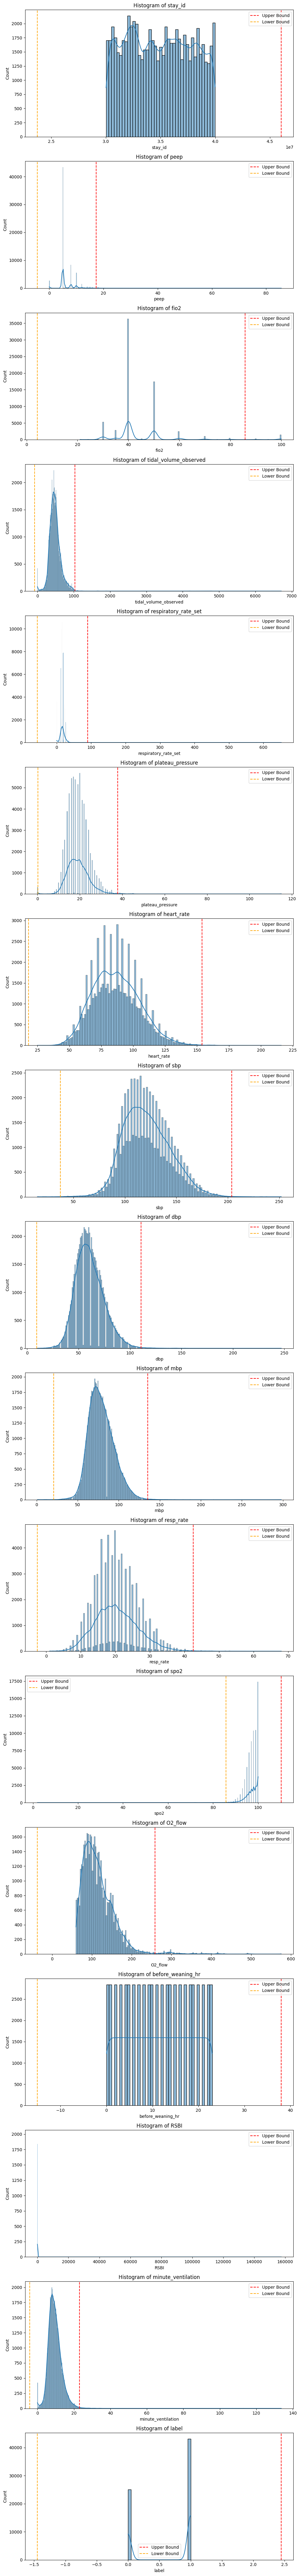

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming pre_24_rows_gt_df is your DataFrame
# Drop non-numeric columns for simplicity in the example
numeric_cols = pre_24_rows_gt_df.select_dtypes(include='number').columns

# Set up subplots
fig, axes = plt.subplots(nrows=len(numeric_cols), ncols=1, figsize=(10, 5 * len(numeric_cols)))

# Iterate through numeric columns and create histograms
for i, col in enumerate(numeric_cols):
    sns.histplot(pre_24_rows_gt_df[col], kde=True, ax=axes[i])
    
    # Calculate 75th percentile and 25th percentile
    p75 = pre_24_rows_gt_df[col].quantile(0.75)
    p25 = pre_24_rows_gt_df[col].quantile(0.25)
    
    # Calculate upper and lower bounds for outliers
    upper_bound = p75 + 3 * pre_24_rows_gt_df[col].std()
    lower_bound = p25 - 3 * pre_24_rows_gt_df[col].std()
    
    # Add lines for upper and lower bounds
    axes[i].axvline(upper_bound, color='red', linestyle='dashed', label='Upper Bound')
    axes[i].axvline(lower_bound, color='orange', linestyle='dashed', label='Lower Bound')
    
    axes[i].set_title(f'Histogram of {col}')
    axes[i].legend()

# Adjust layout
plt.tight_layout()
plt.show()

In [42]:
# Assuming pre_24_rows_gt_df is your DataFrame
column_stats = pre_24_rows_gt_df.describe(include='all')

# Print mean, std, min, and max for each column
for col in pre_24_rows_gt_df.columns:
    print(f"Column: {col}")
    print(f"Mean: {column_stats.loc['mean', col]}")
    print(f"Std: {column_stats.loc['std', col]}")
    print(f"Min: {column_stats.loc['min', col]}")
    print(f"Max: {column_stats.loc['max', col]}")
    # Calculate and print 3 std + 75% and 25% - 3 std
    upper_limit = column_stats.loc['75%', col] + 3 * column_stats.loc['std', col]
    lower_limit = column_stats.loc['25%', col] - 3 * column_stats.loc['std', col]
    print(f"75% + 3 Std: {upper_limit}")
    print(f"25% - 3 Std: {lower_limit}")
    print()

Column: stay_id
Mean: 34911742.42887324
Std: 2888138.029801804
Min: 30005707.0
Max: 39995735.0
75% + 3 Std: 46046330.83940541
25% - 3 Std: 23724774.91059459

Column: charttime
Mean: nan
Std: nan
Min: nan
Max: nan
75% + 3 Std: nan
25% - 3 Std: nan

Column: peep
Mean: 6.338026701877934
Std: 3.117888221745228
Min: 0.0
Max: 85.6
75% + 3 Std: 17.353664665235684
25% - 3 Std: -4.353664665235684

Column: fio2
Mean: 44.45382922535211
Std: 11.911911741909002
Min: 21.0
Max: 100.0
75% + 3 Std: 85.73573522572701
25% - 3 Std: 4.264264774272995

Column: tidal_volume_observed
Mean: 484.6331228477112
Std: 157.2722104934631
Min: 0.0
Max: 6712.0
75% + 3 Std: 1029.8166314803893
25% - 3 Std: -79.81663148038928

Column: respiratory_rate_set
Mean: 17.30141891093787
Std: 23.288024755264793
Min: 0.0
Max: 652.0
75% + 3 Std: 89.86407426579439
25% - 3 Std: -55.864074265794386

Column: plateau_pressure
Mean: 19.123819419347065
Std: 5.267281786584544
Min: 0.0
Max: 115.0
75% + 3 Std: 37.80184535975363
25% - 3 Std: 0

C:\Users\張亞錫\AppData\Local\Temp\ipykernel_56824\2251467175.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  column_stats = pre_24_rows_gt_df.describe(include='all')


### Deal with outlier by costum boundary

In [43]:
def filter_outliers(df, reasonable_ranges, outlier_threshold=3):
    for feature, (lower_limit, upper_limit) in reasonable_ranges.items():
        # Filter outliers for each feature based on the specified range
        feature_outliers = (
            (df[feature] < lower_limit) | (df[feature] > upper_limit)
        )
        
        # Replace outliers with NaN in the original DataFrame
        df.loc[feature_outliers, feature] = np.nan

    return df


# Example of setting reasonable ranges
reasonable_ranges = {
    'peep': (0, 20),
    'fio2': (0, 100),
    'tidal_volume_observed': (0, 1250),
    'respiratory_rate_set': (0, 50),
    'plateau_pressure': (0, 40),
    'heart_rate': (25, 216),
    'sbp': (15, 252),
    'dbp': (10, 247),
    'mbp': (1, 298),
    'resp_rate': (1, 68),
    'spo2': (2, 100),
    'O2_flow': (60, 576),
    'before_weaning_hr': (0, 23),
}

# Example usage
pre_24_rows_gt_filter_df= filter_outliers(pre_24_rows_gt_df, reasonable_ranges)
pre_24_rows_gt_fill_df = fill_Nan(pre_24_rows_gt_filter_df)
# Display filtered DataFrame and outliers DataFrame
print("Filtered DataFrame:")
pre_24_rows_gt_fill_df


C:\Users\張亞錫\AppData\Local\Temp\ipykernel_56824\2100203199.py:7: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df = df.groupby('stay_id').apply(lambda group: group.ffill().bfill())


Filtered DataFrame:


,stay_id,charttime,peep,fio2,tidal_volume_observed,respiratory_rate_set,plateau_pressure,heart_rate,sbp,dbp,mbp,resp_rate,spo2,O2_flow,ventilator_mode,before_weaning_hr,RSBI,minute_ventilation,ventilator_mode_group,label
0,30005707,2144-01-11 20:00:00,5.0,40.0,530.0,10.0,17.0,67.0,115.0,54.0,74.0,11.0,94.0,119.0,MMV/PSV/AutoFlow,23.0,20.754717,5.830,Complete Support,1
1,30005707,2144-01-11 21:00:00,5.0,40.0,530.0,10.0,17.0,73.0,112.0,41.0,67.0,17.0,95.0,119.0,MMV/PSV/AutoFlow,22.0,32.075472,9.010,Complete Support,1
2,30005707,2144-01-11 22:00:00,5.0,40.0,530.0,10.0,17.0,72.0,117.0,51.0,72.0,15.0,96.0,119.0,MMV/PSV/AutoFlow,21.0,28.301887,7.950,Complete Support,1
3,30005707,2144-01-11 23:00:00,5.0,40.0,530.0,10.0,17.0,73.0,123.0,50.0,74.0,15.0,95.0,119.0,MMV/PSV/AutoFlow,20.0,28.301887,7.950,Complete Support,1
4,30005707,2144-01-12 00:00:00,5.0,40.0,498.0,10.0,11.0,72.0,133.0,57.0,83.0,17.0,97.0,119.0,MMV/PSV/AutoFlow,19.0,34.136546,8.466,Complete Support,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68155,39995735,2124-08-21 05:00:00,5.0,40.0,382.0,18.0,20.0,80.0,133.0,61.0,84.0,23.0,95.0,117.0,CPAP/PSV,4.0,60.209424,8.786,Minimal Support,1
68156,39995735,2124-08-21 06:00:00,5.0,50.0,382.0,18.0,20.0,80.0,130.0,57.0,80.0,27.0,94.0,95.0,Standby,3.0,70.680628,10.314,Minimal Support,1
68157,39995735,2124-08-21 07:00:00,5.0,50.0,382.0,18.0,20.0,80.0,131.0,56.0,79.0,21.0,95.0,118.0,Standby,2.0,54.973822,8.022,Minimal Support,1
68158,39995735,2124-08-21 08:00:00,5.0,40.0,382.0,18.0,20.0,82.0,141.0,58.0,82.0,25.0,97.0,118.0,Standby,1.0,65.445026,9.550,Minimal Support,1


### Recalculate 'RSBI' and 'minute_ventilation' after dealing with outliers

In [44]:
pre_24_rows_gt_fill_df['RSBI'] = pre_24_rows_gt_fill_df['resp_rate'] / (pre_24_rows_gt_fill_df['tidal_volume_observed'] * 0.001)
pre_24_rows_gt_fill_df['minute_ventilation'] = pre_24_rows_gt_fill_df['resp_rate'] * (pre_24_rows_gt_fill_df['tidal_volume_observed'] * 0.001)
# Apply the categorization function to create the new column
pre_24_rows_gt_fill_df['ventilator_mode_group'] = pre_24_rows_gt_fill_df['ventilator_mode'].apply(categorize_ventilator_mode)

fill with outliers(inf) as by ffill and bfill

In [45]:
pre_24_rows_gt_fill_df['RSBI'] = pre_24_rows_gt_fill_df['RSBI'].replace(np.inf, np.nan)
pre_24_rows_gt_fill_df = fill_Nan(pre_24_rows_gt_fill_df)

C:\Users\張亞錫\AppData\Local\Temp\ipykernel_56824\2100203199.py:7: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df = df.groupby('stay_id').apply(lambda group: group.ffill().bfill())


In [46]:
pre_24_rows_gt_fill_df[pre_24_rows_gt_fill_df['stay_id'] == 30109194]

,stay_id,charttime,peep,fio2,tidal_volume_observed,respiratory_rate_set,plateau_pressure,heart_rate,sbp,dbp,mbp,resp_rate,spo2,O2_flow,ventilator_mode,before_weaning_hr,RSBI,minute_ventilation,ventilator_mode_group,label
744,30109194,2192-05-18 09:00:00,5.0,40.0,465.0,12.0,31.0,70.0,112.0,73.0,82.0,15.0,100.0,NaN,CPAP/PSV,23.0,32.258065,6.9750,Minimal Support,0
745,30109194,2192-05-18 10:00:00,5.0,40.0,465.0,12.0,31.0,71.0,112.0,73.0,82.0,19.0,100.0,NaN,CPAP/PSV,22.0,40.860215,8.8350,Minimal Support,0
746,30109194,2192-05-18 11:00:00,5.0,40.0,465.0,12.0,31.0,70.0,105.0,62.0,69.0,19.0,98.0,NaN,CPAP/PSV,21.0,40.860215,8.8350,Minimal Support,0
747,30109194,2192-05-18 12:00:00,5.0,40.0,465.0,12.0,31.0,67.0,116.0,66.0,77.0,26.0,100.0,NaN,CPAP/PSV,20.0,55.913978,12.0900,Minimal Support,0
748,30109194,2192-05-18 13:00:00,5.0,40.0,465.0,12.0,31.0,67.0,138.0,91.0,100.0,28.0,100.0,NaN,CPAP/PSV,19.0,60.215054,13.0200,Minimal Support,0
749,30109194,2192-05-18 14:00:00,5.0,40.0,465.0,12.0,31.0,71.0,124.0,79.0,90.0,28.0,100.0,NaN,CPAP/PSV,18.0,60.215054,13.0200,Minimal Support,0
750,30109194,2192-05-18 15:00:00,5.0,40.0,506.0,12.0,31.0,67.0,124.0,79.0,90.0,23.0,100.0,NaN,CPAP/PSV,17.0,45.454545,11.6380,Minimal Support,0
751,30109194,2192-05-18 16:00:00,5.0,40.0,506.0,12.0,31.0,67.0,124.0,79.0,90.0,18.0,100.0,NaN,CPAP/PSV,16.0,35.573123,9.1080,Minimal Support,0
752,30109194,2192-05-18 17:00:00,5.0,40.0,506.0,12.0,31.0,76.0,127.0,87.0,95.0,23.0,100.0,NaN,CPAP/PSV,15.0,45.454545,11.6380,Minimal Support,0
753,30109194,2192-05-18 18:00:00,5.0,40.0,506.0,12.0,31.0,76.0,108.0,89.0,97.0,27.0,100.0,NaN,CPAP/PSV,14.0,53.359684,13.6620,Minimal Support,0


### Show tableone for the Baseline features after dealing with outliers

In [47]:
features_col = ['peep', 'fio2', 'tidal_volume_observed', 'respiratory_rate_set', 
                'plateau_pressure', 'heart_rate', 'sbp', 'dbp', 'mbp', 
                'resp_rate', 'spo2', 'O2_flow', 'RSBI', 'minute_ventilation', 'label']
categorical = []
groupby = ['label']
table_without_outlier = TableOne(pre_24_rows_gt_fill_df, columns=features_col, categorical=categorical, groupby=groupby, pval=True)
table_without_outlier

Grouped by label                                                     
                                           Missing        Overall              0              1 P-Value
n                                                           68160          25080          43080        
peep, mean (SD)                                 72      6.3 (3.0)      7.2 (3.5)      5.8 (2.5)  <0.001
fio2, mean (SD)                                  0    44.5 (11.9)    47.4 (15.0)     42.8 (9.2)  <0.001
tidal_volume_observed, mean (SD)                 0  483.7 (146.3)  477.4 (140.0)  487.3 (149.8)  <0.001
respiratory_rate_set, mean (SD)                528     16.4 (6.4)     17.6 (6.6)     15.7 (6.1)  <0.001
plateau_pressure, mean (SD)                   1800     19.1 (5.0)     20.1 (5.6)     18.5 (4.5)  <0.001
heart_rate, mean (SD)                            0    86.6 (18.3)    88.9 (19.0)    85.4 (17.7)  <0.001
sbp, mean (SD)                                   0   121.4 (22.6)   118.2 (23.6)   123.2 (21.8)  <0.001
dbp, mean (SD)                                   0    61.0 (13.9)    58.9 (14.0)    62.2 (13.8)  <0.001
mbp, mean (SD)                                   0    79.0 (15.8)    76.5 (15.9)    80.4 (15.5)  <0.001
resp_rate, mean (SD)                             0     20.4 (6.2)     21.6 (6.4)     19.6 (5.9)  <0.001
spo2, mean (SD)                                  0     97.3 (3.4)     96.8 (4.5)     97.5 (2.6)  <0.001
O2_flow, mean (SD)                           22920   115.8 (41.3)   114.8 (43.5)   116.3 (40.0)  <0.001
RSBI, mean (SD)                                  0  79.0 (1488.1)  87.5 (1261.7)  74.0 (1605.2)   0.226
minute_ventilation, mean (SD)                    0      9.6 (3.6)     10.1 (3.8)      9.3 (3.4)  <0.001

quick look at missing val

In [48]:
feature_for_miss = "respiratory_rate_set" # you can change this for quick look at the missing (0 records for the raw data)
# Count occurrences of 0 in feature_for_miss for each "stay_id"
counts = ventilator_setting_df[["stay_id", feature_for_miss]].groupby("stay_id").count()

# Count how many stay_id have count of 0 for feature_for_miss
zero_count_stay_id = (counts[feature_for_miss] == 0).sum()

# Display the result
print("Number of stay_id with count of 0 for respiratory_rate_set:", zero_count_stay_id)

Number of stay_id with count of 0 for respiratory_rate_set: 15


In [49]:
pre_24_rows_gt_fill_df

,stay_id,charttime,peep,fio2,tidal_volume_observed,respiratory_rate_set,plateau_pressure,heart_rate,sbp,dbp,mbp,resp_rate,spo2,O2_flow,ventilator_mode,before_weaning_hr,RSBI,minute_ventilation,ventilator_mode_group,label
0,30005707,2144-01-11 20:00:00,5.0,40.0,530.0,10.0,17.0,67.0,115.0,54.0,74.0,11.0,94.0,119.0,MMV/PSV/AutoFlow,23.0,20.754717,5.830,Complete Support,1
1,30005707,2144-01-11 21:00:00,5.0,40.0,530.0,10.0,17.0,73.0,112.0,41.0,67.0,17.0,95.0,119.0,MMV/PSV/AutoFlow,22.0,32.075472,9.010,Complete Support,1
2,30005707,2144-01-11 22:00:00,5.0,40.0,530.0,10.0,17.0,72.0,117.0,51.0,72.0,15.0,96.0,119.0,MMV/PSV/AutoFlow,21.0,28.301887,7.950,Complete Support,1
3,30005707,2144-01-11 23:00:00,5.0,40.0,530.0,10.0,17.0,73.0,123.0,50.0,74.0,15.0,95.0,119.0,MMV/PSV/AutoFlow,20.0,28.301887,7.950,Complete Support,1
4,30005707,2144-01-12 00:00:00,5.0,40.0,498.0,10.0,11.0,72.0,133.0,57.0,83.0,17.0,97.0,119.0,MMV/PSV/AutoFlow,19.0,34.136546,8.466,Complete Support,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68155,39995735,2124-08-21 05:00:00,5.0,40.0,382.0,18.0,20.0,80.0,133.0,61.0,84.0,23.0,95.0,117.0,CPAP/PSV,4.0,60.209424,8.786,Minimal Support,1
68156,39995735,2124-08-21 06:00:00,5.0,50.0,382.0,18.0,20.0,80.0,130.0,57.0,80.0,27.0,94.0,95.0,Standby,3.0,70.680628,10.314,Minimal Support,1
68157,39995735,2124-08-21 07:00:00,5.0,50.0,382.0,18.0,20.0,80.0,131.0,56.0,79.0,21.0,95.0,118.0,Standby,2.0,54.973822,8.022,Minimal Support,1
68158,39995735,2124-08-21 08:00:00,5.0,40.0,382.0,18.0,20.0,82.0,141.0,58.0,82.0,25.0,97.0,118.0,Standby,1.0,65.445026,9.550,Minimal Support,1


### Merge features to csv

In [50]:
pre_24_rows_merged = pd.merge(pre_24_rows_gt_fill_df, baseline_fill_w_h_df, on=["stay_id", "label"], how="inner")
pre_24_rows_merged.drop('O2_flow', axis=1, inplace=True)

drop those having missing for all 24 rows

In [51]:
pre_24_rows_merged.columns

Index(['stay_id', 'charttime', 'peep', 'fio2', 'tidal_volume_observed',
       'respiratory_rate_set', 'plateau_pressure', 'heart_rate', 'sbp', 'dbp',
       'mbp', 'resp_rate', 'spo2', 'ventilator_mode', 'before_weaning_hr',
       'RSBI', 'minute_ventilation', 'ventilator_mode_group', 'label',
       'subject_id', 'hadm_id', 'age_now', 'gender', 'insurance', 'race',
       'admission_type', 'first_careunit', 'weight_kg', 'height_cm',
       'tobacco'],
      dtype='object')

In [52]:
# Identify stay_ids with missing values
stay_ids_with_missing_values = pre_24_rows_merged.loc[pre_24_rows_merged.isnull().any(axis=1), 'stay_id'].unique()

# Create a DataFrame to store dropped rows
drop_df = pre_24_rows_merged[pre_24_rows_merged['stay_id'].isin(stay_ids_with_missing_values)].copy()

# Drop all records with specified stay_ids
pre_24_rows_merged_without_miss = pre_24_rows_merged[~pre_24_rows_merged['stay_id'].isin(stay_ids_with_missing_values)]

# Display or further process drop_df and pre_24_rows_merged_without_miss


In [53]:
drop_df

,stay_id,charttime,peep,fio2,tidal_volume_observed,respiratory_rate_set,plateau_pressure,heart_rate,sbp,dbp,...,hadm_id,age_now,gender,insurance,race,admission_type,first_careunit,weight_kg,height_cm,tobacco
360,30045625,2200-05-21 09:00:00,12.0,40.0,438.0,18.0,18.0,110.0,199.0,92.0,...,26086792,67,F,Other,WHITE,URGENT,Medical Intensive Care Unit (MICU),83.6,165.000000,0
361,30045625,2200-05-21 10:00:00,12.0,40.0,438.0,18.0,18.0,110.0,136.0,60.0,...,26086792,67,F,Other,WHITE,URGENT,Medical Intensive Care Unit (MICU),83.6,165.000000,0
362,30045625,2200-05-21 11:00:00,12.0,40.0,438.0,18.0,18.0,98.0,104.0,59.0,...,26086792,67,F,Other,WHITE,URGENT,Medical Intensive Care Unit (MICU),83.6,165.000000,0
363,30045625,2200-05-21 12:00:00,12.0,40.0,438.0,18.0,18.0,92.0,117.0,60.0,...,26086792,67,F,Other,WHITE,URGENT,Medical Intensive Care Unit (MICU),83.6,165.000000,0
364,30045625,2200-05-21 13:00:00,12.0,40.0,438.0,18.0,18.0,90.0,97.0,56.0,...,26086792,67,F,Other,WHITE,URGENT,Medical Intensive Care Unit (MICU),83.6,165.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68107,39986786,2145-02-23 08:00:00,5.0,40.0,491.0,10.0,21.0,85.0,126.0,52.0,...,21472938,72,M,Medicare,ASIAN - CHINESE,EW EMER.,Coronary Care Unit (CCU),67.5,170.333333,1
68108,39986786,2145-02-23 09:00:00,5.0,40.0,491.0,10.0,21.0,93.0,138.0,57.0,...,21472938,72,M,Medicare,ASIAN - CHINESE,EW EMER.,Coronary Care Unit (CCU),67.5,170.333333,1
68109,39986786,2145-02-23 10:00:00,5.0,40.0,491.0,10.0,21.0,78.0,135.0,53.0,...,21472938,72,M,Medicare,ASIAN - CHINESE,EW EMER.,Coronary Care Unit (CCU),67.5,170.333333,1
68110,39986786,2145-02-23 11:00:00,5.0,40.0,491.0,10.0,21.0,78.0,147.0,59.0,...,21472938,72,M,Medicare,ASIAN - CHINESE,EW EMER.,Coronary Care Unit (CCU),67.5,170.333333,1


In [54]:
features_col = ['RSBI', 'minute_ventilation', 'ventilator_mode_group', 'peep', 'fio2', 'tidal_volume_observed', 'respiratory_rate_set', 'plateau_pressure', 'heart_rate', 'sbp', 'dbp', 'mbp', 'resp_rate', 'spo2', 'label']
categorical = ['ventilator_mode_group']
groupby = ['label']
table_without_miss_and_outlier = TableOne(pre_24_rows_merged_without_miss, columns=features_col, categorical=categorical, groupby=groupby, pval=True)
table_without_miss_and_outlier

Grouped by label                                                     
                                                           Missing        Overall              0              1 P-Value
n                                                                           63912          23304          40608        
RSBI, mean (SD)                                                  0   55.8 (358.5)   57.4 (336.3)   55.0 (370.6)   0.407
minute_ventilation, mean (SD)                                    0      9.6 (3.6)     10.2 (3.8)      9.3 (3.4)  <0.001
ventilator_mode_group, n (%)     Complete Support                0   20492 (32.1)   10179 (43.7)   10313 (25.4)  <0.001
                                 Minimal Support                     43338 (67.8)   13095 (56.2)   30243 (74.5)        
                                 Partial Support                         82 (0.1)       30 (0.1)       52 (0.1)        
peep, mean (SD)                                                  0      6.3 (2.9)      7.1 (3.4)      5.7 (2.4)  <0.001
fio2, mean (SD)                                                  0    44.5 (11.9)    47.5 (15.0)     42.7 (9.2)  <0.001
tidal_volume_observed, mean (SD)                                 0  485.1 (146.4)  479.4 (140.4)  488.3 (149.7)  <0.001
respiratory_rate_set, mean (SD)                                  0     16.3 (6.3)     17.6 (6.5)     15.6 (6.1)  <0.001
plateau_pressure, mean (SD)                                      0     19.0 (4.9)     20.1 (5.5)     18.4 (4.5)  <0.001
heart_rate, mean (SD)                                            0    86.8 (18.2)    89.1 (18.9)    85.4 (17.7)  <0.001
sbp, mean (SD)                                                   0   121.4 (22.6)   118.2 (23.5)   123.3 (21.8)  <0.001
dbp, mean (SD)                                                   0    61.1 (14.0)    59.0 (14.0)    62.3 (13.8)  <0.001
mbp, mean (SD)                                                   0    79.1 (15.9)    76.6 (16.0)    80.5 (15.6)  <0.001
resp_rate, mean (SD)                                             0     20.3 (6.2)     21.6 (6.4)     19.6 (5.9)  <0.001
spo2, mean (SD)                                                  0     97.3 (3.3)     96.9 (4.3)     97.5 (2.6)  <0.001

In [55]:
column_order = ['subject_id', 'stay_id', 'hadm_id', 'charttime', 'before_weaning_hr', 'age_now', 'gender', 'insurance', 'race', 'first_careunit', 'admission_type', 'weight_kg', 'height_cm', 'tobacco', 'RSBI', 'minute_ventilation', 'ventilator_mode', 'ventilator_mode_group', 'peep', 'fio2', 'tidal_volume_observed', 'respiratory_rate_set', 'plateau_pressure', 'heart_rate', 'sbp', 'dbp', 'mbp', 'resp_rate', 'spo2', 'label']
len(column_order)

30

In [64]:
# Reorder the DataFrame based on the desired column order
pre_24_rows_merged_ordered = pre_24_rows_merged_without_miss[column_order]
pre_24_rows_merged_ordered.to_csv("data/data_by_table/pre_24_merged_30_rows_12_07.csv", index=False)

take a look at the last hour, whether the std is smaller

In [57]:
last_hr_df = pre_24_rows_merged_ordered[pre_24_rows_merged_ordered["before_weaning_hr"] == 0]
first_hr_df = pre_24_rows_merged_ordered[pre_24_rows_merged_ordered["before_weaning_hr"] == 23]

In [58]:
features_col = ['RSBI', 'minute_ventilation', 'ventilator_mode_group', 'peep', 'fio2', 'tidal_volume_observed', 'respiratory_rate_set', 'plateau_pressure', 'heart_rate', 'sbp', 'dbp', 'mbp', 'resp_rate', 'spo2', 'label']
categorical = ['ventilator_mode_group']
groupby = ['label']
table_done = TableOne(pre_24_rows_merged_ordered, columns=features_col, categorical=categorical, groupby=groupby, pval=True)
table_done

Grouped by label                                                     
                                                           Missing        Overall              0              1 P-Value
n                                                                           63912          23304          40608        
RSBI, mean (SD)                                                  0   55.8 (358.5)   57.4 (336.3)   55.0 (370.6)   0.407
minute_ventilation, mean (SD)                                    0      9.6 (3.6)     10.2 (3.8)      9.3 (3.4)  <0.001
ventilator_mode_group, n (%)     Complete Support                0   20492 (32.1)   10179 (43.7)   10313 (25.4)  <0.001
                                 Minimal Support                     43338 (67.8)   13095 (56.2)   30243 (74.5)        
                                 Partial Support                         82 (0.1)       30 (0.1)       52 (0.1)        
peep, mean (SD)                                                  0      6.3 (2.9)      7.1 (3.4)      5.7 (2.4)  <0.001
fio2, mean (SD)                                                  0    44.5 (11.9)    47.5 (15.0)     42.7 (9.2)  <0.001
tidal_volume_observed, mean (SD)                                 0  485.1 (146.4)  479.4 (140.4)  488.3 (149.7)  <0.001
respiratory_rate_set, mean (SD)                                  0     16.3 (6.3)     17.6 (6.5)     15.6 (6.1)  <0.001
plateau_pressure, mean (SD)                                      0     19.0 (4.9)     20.1 (5.5)     18.4 (4.5)  <0.001
heart_rate, mean (SD)                                            0    86.8 (18.2)    89.1 (18.9)    85.4 (17.7)  <0.001
sbp, mean (SD)                                                   0   121.4 (22.6)   118.2 (23.5)   123.3 (21.8)  <0.001
dbp, mean (SD)                                                   0    61.1 (14.0)    59.0 (14.0)    62.3 (13.8)  <0.001
mbp, mean (SD)                                                   0    79.1 (15.9)    76.6 (16.0)    80.5 (15.6)  <0.001
resp_rate, mean (SD)                                             0     20.3 (6.2)     21.6 (6.4)     19.6 (5.9)  <0.001
spo2, mean (SD)                                                  0     97.3 (3.3)     96.9 (4.3)     97.5 (2.6)  <0.001

In [59]:
features_col = ['RSBI', 'minute_ventilation', 'ventilator_mode_group', 'peep', 'fio2', 'tidal_volume_observed', 'respiratory_rate_set', 'plateau_pressure', 'heart_rate', 'sbp', 'dbp', 'mbp', 'resp_rate', 'spo2', 'label']
categorical = ['ventilator_mode_group']
groupby = ['label']
table_done_last_hr = TableOne(last_hr_df, columns=features_col, categorical=categorical, groupby=groupby, pval=True)
table_done_last_hr

Grouped by label                                                     
                                                           Missing        Overall              0              1 P-Value
n                                                                            2663            971           1692        
RSBI, mean (SD)                                                  0   80.4 (705.2)  104.4 (989.4)   66.7 (469.8)   0.264
minute_ventilation, mean (SD)                                    0      9.9 (4.2)     10.3 (4.3)      9.6 (4.0)  <0.001
ventilator_mode_group, n (%)     Complete Support                0     486 (18.3)     339 (34.9)      147 (8.7)  <0.001
                                 Minimal Support                      2177 (81.7)     632 (65.1)    1545 (91.3)        
peep, mean (SD)                                                  0      5.4 (3.1)      6.5 (3.6)      4.7 (2.6)  <0.001
fio2, mean (SD)                                                  0    49.2 (16.4)    51.6 (18.9)    47.8 (14.6)  <0.001
tidal_volume_observed, mean (SD)                                 0  464.7 (171.4)  457.1 (161.0)  469.0 (177.0)   0.075
respiratory_rate_set, mean (SD)                                  0     16.0 (6.6)     17.4 (6.7)     15.1 (6.3)  <0.001
plateau_pressure, mean (SD)                                      0     19.0 (5.0)     20.1 (5.7)     18.3 (4.5)  <0.001
heart_rate, mean (SD)                                            0    89.9 (18.8)    91.2 (20.5)    89.1 (17.8)   0.008
sbp, mean (SD)                                                   0   126.1 (25.6)   119.6 (29.2)   129.8 (22.5)  <0.001
dbp, mean (SD)                                                   0    63.7 (15.2)    60.2 (15.9)    65.8 (14.4)  <0.001
mbp, mean (SD)                                                   0    82.4 (18.1)    77.9 (19.4)    85.0 (16.8)  <0.001
resp_rate, mean (SD)                                             0     21.7 (6.2)     23.1 (6.5)     20.9 (5.9)  <0.001
spo2, mean (SD)                                                  0     96.4 (5.3)     95.3 (7.9)     97.0 (2.8)  <0.001

In [65]:
features_col = ['peep', 'fio2', 'respiratory_rate_set', 'plateau_pressure', 'ventilator_mode_group', 'heart_rate', 'sbp', 'dbp', 'mbp', 'resp_rate', 'spo2', 'tidal_volume_observed', 'RSBI', 'minute_ventilation', 'label']
categorical = ['ventilator_mode_group']
groupby = ['label']
table_done_last_hr = TableOne(last_hr_df, columns=features_col, categorical=categorical, groupby=groupby, pval=True)
table_done_last_hr

Grouped by label                                                     
                                                           Missing        Overall              0              1 P-Value
n                                                                            2663            971           1692        
peep, mean (SD)                                                  0      5.4 (3.1)      6.5 (3.6)      4.7 (2.6)  <0.001
fio2, mean (SD)                                                  0    49.2 (16.4)    51.6 (18.9)    47.8 (14.6)  <0.001
respiratory_rate_set, mean (SD)                                  0     16.0 (6.6)     17.4 (6.7)     15.1 (6.3)  <0.001
plateau_pressure, mean (SD)                                      0     19.0 (5.0)     20.1 (5.7)     18.3 (4.5)  <0.001
ventilator_mode_group, n (%)     Complete Support                0     486 (18.3)     339 (34.9)      147 (8.7)  <0.001
                                 Minimal Support                      2177 (81.7)     632 (65.1)    1545 (91.3)        
heart_rate, mean (SD)                                            0    89.9 (18.8)    91.2 (20.5)    89.1 (17.8)   0.008
sbp, mean (SD)                                                   0   126.1 (25.6)   119.6 (29.2)   129.8 (22.5)  <0.001
dbp, mean (SD)                                                   0    63.7 (15.2)    60.2 (15.9)    65.8 (14.4)  <0.001
mbp, mean (SD)                                                   0    82.4 (18.1)    77.9 (19.4)    85.0 (16.8)  <0.001
resp_rate, mean (SD)                                             0     21.7 (6.2)     23.1 (6.5)     20.9 (5.9)  <0.001
spo2, mean (SD)                                                  0     96.4 (5.3)     95.3 (7.9)     97.0 (2.8)  <0.001
tidal_volume_observed, mean (SD)                                 0  464.7 (171.4)  457.1 (161.0)  469.0 (177.0)   0.075
RSBI, mean (SD)                                                  0   80.4 (705.2)  104.4 (989.4)   66.7 (469.8)   0.264
minute_ventilation, mean (SD)                                    0      9.9 (4.2)     10.3 (4.3)      9.6 (4.0)  <0.001

In [61]:
features_col = ['RSBI', 'minute_ventilation', 'ventilator_mode_group', 'peep', 'fio2', 'tidal_volume_observed', 'respiratory_rate_set', 'plateau_pressure', 'heart_rate', 'sbp', 'dbp', 'mbp', 'resp_rate', 'spo2', 'label']
categorical = ['ventilator_mode_group']
groupby = ['label']
table_done_first_hr = TableOne(first_hr_df, columns=features_col, categorical=categorical, groupby=groupby, pval=True)
table_done_first_hr

Grouped by label                                                     
                                                           Missing        Overall              0              1 P-Value
n                                                                            2663            971           1692        
RSBI, mean (SD)                                                  0   48.8 (125.5)    49.5 (28.0)   48.4 (156.0)   0.783
minute_ventilation, mean (SD)                                    0      9.6 (3.5)     10.2 (3.8)      9.3 (3.3)  <0.001
ventilator_mode_group, n (%)     Complete Support                0     972 (36.5)     458 (47.2)     514 (30.4)  <0.001
                                 Minimal Support                      1685 (63.3)     512 (52.7)    1173 (69.3)        
                                 Partial Support                          6 (0.2)        1 (0.1)        5 (0.3)        
peep, mean (SD)                                                  0      6.6 (2.9)      7.3 (3.3)      6.2 (2.5)  <0.001
fio2, mean (SD)                                                  0    44.2 (11.4)    47.3 (14.6)     42.4 (8.5)  <0.001
tidal_volume_observed, mean (SD)                                 0  488.0 (140.1)  483.5 (136.5)  490.7 (142.0)   0.198
respiratory_rate_set, mean (SD)                                  0     16.5 (6.2)     17.7 (6.3)     15.9 (6.0)  <0.001
plateau_pressure, mean (SD)                                      0     19.1 (4.9)     20.0 (5.5)     18.6 (4.5)  <0.001
heart_rate, mean (SD)                                            0    86.4 (18.1)    88.4 (18.9)    85.3 (17.5)  <0.001
sbp, mean (SD)                                                   0   120.0 (21.7)   117.3 (21.9)   121.5 (21.4)  <0.001
dbp, mean (SD)                                                   0    60.4 (13.4)    58.4 (13.1)    61.5 (13.4)  <0.001
mbp, mean (SD)                                                   0    78.3 (15.5)    76.0 (14.6)    79.5 (15.9)  <0.001
resp_rate, mean (SD)                                             0     20.2 (6.1)     21.5 (6.1)     19.5 (5.9)  <0.001
spo2, mean (SD)                                                  0     97.4 (2.7)     97.2 (2.9)     97.5 (2.6)   0.007
[1] Chi-squared tests for the following variables may be invalid due to the low number of observations: ventilator_mode_group.

In [67]:
features_col = ['peep', 'fio2', 'respiratory_rate_set', 'plateau_pressure', 'ventilator_mode_group', 'heart_rate', 'sbp', 'dbp', 'mbp', 'resp_rate', 'spo2', 'tidal_volume_observed', 'RSBI', 'minute_ventilation', 'label']
categorical = ['ventilator_mode_group']
groupby = ['label']
table_done_first_hr = TableOne(first_hr_df, columns=features_col, categorical=categorical, groupby=groupby, pval=True)
table_done_first_hr

Grouped by label                                                     
                                                           Missing        Overall              0              1 P-Value
n                                                                            2663            971           1692        
peep, mean (SD)                                                  0      6.6 (2.9)      7.3 (3.3)      6.2 (2.5)  <0.001
fio2, mean (SD)                                                  0    44.2 (11.4)    47.3 (14.6)     42.4 (8.5)  <0.001
respiratory_rate_set, mean (SD)                                  0     16.5 (6.2)     17.7 (6.3)     15.9 (6.0)  <0.001
plateau_pressure, mean (SD)                                      0     19.1 (4.9)     20.0 (5.5)     18.6 (4.5)  <0.001
ventilator_mode_group, n (%)     Complete Support                0     972 (36.5)     458 (47.2)     514 (30.4)  <0.001
                                 Minimal Support                      1685 (63.3)     512 (52.7)    1173 (69.3)        
                                 Partial Support                          6 (0.2)        1 (0.1)        5 (0.3)        
heart_rate, mean (SD)                                            0    86.4 (18.1)    88.4 (18.9)    85.3 (17.5)  <0.001
sbp, mean (SD)                                                   0   120.0 (21.7)   117.3 (21.9)   121.5 (21.4)  <0.001
dbp, mean (SD)                                                   0    60.4 (13.4)    58.4 (13.1)    61.5 (13.4)  <0.001
mbp, mean (SD)                                                   0    78.3 (15.5)    76.0 (14.6)    79.5 (15.9)  <0.001
resp_rate, mean (SD)                                             0     20.2 (6.1)     21.5 (6.1)     19.5 (5.9)  <0.001
spo2, mean (SD)                                                  0     97.4 (2.7)     97.2 (2.9)     97.5 (2.6)   0.007
tidal_volume_observed, mean (SD)                                 0  488.0 (140.1)  483.5 (136.5)  490.7 (142.0)   0.198
RSBI, mean (SD)                                                  0   48.8 (125.5)    49.5 (28.0)   48.4 (156.0)   0.783
minute_ventilation, mean (SD)                                    0      9.6 (3.5)     10.2 (3.8)      9.3 (3.3)  <0.001
[1] Chi-squared tests for the following variables may be invalid due to the low number of observations: ventilator_mode_group.

### Jerry data for tableone

In [3]:
pre_24h_data_v4_df = pd.read_csv("data/data_by_table/pre_24h_data_v4.csv")

In [4]:
pre_24h_data_v4_df.columns

Index(['Unnamed: 0', 'charttime', 'stay_id', 'O2_flow_x', 'heart_rate', 'sbp',
       'dbp', 'mbp', 'resp_rate', 'spo2', 'O2_flow_y', 'peep', 'fio2',
       'tidal_volume_observed', 'respiratory_rate_set', 'plateau_pressure',
       'GCS', 'age_now', 'gender', 'insurance', 'race', 'admission_type',
       'first_careunit', 'weight_kg', 'height_cm', 'tobacco', 'label', 'Rev_h',
       'dod_h'],
      dtype='object')

In [6]:
features_col = ['peep', 'fio2', 'respiratory_rate_set', 'plateau_pressure', 'heart_rate', 'sbp', 'dbp', 'mbp', 'resp_rate', 'spo2', 'tidal_volume_observed', 'label']
categorical = []
groupby = ['label']
table_done_first_hr = TableOne(pre_24h_data_v4_df, columns=features_col, categorical=categorical, groupby=groupby, pval=True)
table_done_first_hr

Grouped by label                                                     
                                           Missing        Overall              0              1 P-Value
n                                                           68160          25080          43080        
peep, mean (SD)                                  0      6.3 (3.1)      7.2 (3.6)      5.8 (2.7)  <0.001
fio2, mean (SD)                                  0    44.5 (12.0)    47.4 (15.1)     42.8 (9.3)  <0.001
respiratory_rate_set, mean (SD)                360    17.5 (24.9)    18.2 (18.6)    17.1 (27.9)  <0.001
plateau_pressure, mean (SD)                   1536     19.1 (5.3)     20.2 (5.8)     18.5 (4.9)  <0.001
heart_rate, mean (SD)                         5880    86.7 (17.9)    88.8 (18.6)    85.5 (17.4)  <0.001
sbp, mean (SD)                                5880   123.9 (22.8)   121.1 (23.8)   125.5 (22.1)  <0.001
dbp, mean (SD)                                5880    62.4 (14.5)    60.4 (14.5)    63.5 (14.3)  <0.001
mbp, mean (SD)                                5880    80.9 (16.8)    78.6 (16.8)    82.2 (16.6)  <0.001
resp_rate, mean (SD)                          5880     20.2 (6.0)     21.5 (6.2)     19.5 (5.8)  <0.001
spo2, mean (SD)                               5880     97.4 (3.2)     97.1 (4.2)     97.6 (2.4)  <0.001
tidal_volume_observed, mean (SD)                 0  484.8 (157.4)  479.2 (167.1)  488.0 (151.4)  <0.001